In [1]:
import pandas as pd


In [2]:
df = pd.read_pickle("32B_all_trials_scored.pkl")
df[["kld", "nss", "sim", "attn_score"]].corr()

,kld,nss,sim,attn_score
kld,1.000000,-0.467858,-0.905741,0.069009
nss,-0.467858,1.000000,0.396530,-0.067665
sim,-0.905741,0.396530,1.000000,-0.031838
attn_score,0.069009,-0.067665,-0.031838,1.000000


=== KLD 편차가 큰 상위 5개 Case ===
                     count      mean       std       min       max     range  \
case_id                                                                        
swing_tennis_racket     20  2.233872  1.192873  1.412795  5.135436  3.722641   
throw_javelin           20  1.078231  1.124981  0.168838  2.582492  2.413653   
wash_cup                 5  1.964930  0.845505  1.048704  3.010418  1.961715   
hold_tennis_racket      20  1.003007  0.830494  0.185125  1.914872  1.729747   
push_bicycle            20  2.321077  0.809533  0.651026  2.914423  2.263397   

                           cv  
case_id                        
swing_tennis_racket  0.533993  
throw_javelin        1.043358  
wash_cup             0.430298  
hold_tennis_racket   0.828005  
push_bicycle         0.348775  

=== KLD 표준편차(std)의 전체 분포 통계 ===
count    121.000000
mean       0.185430
std        0.219862
min        0.003337
25%        0.042466
50%        0.113212
75%        0.224261
max        1.

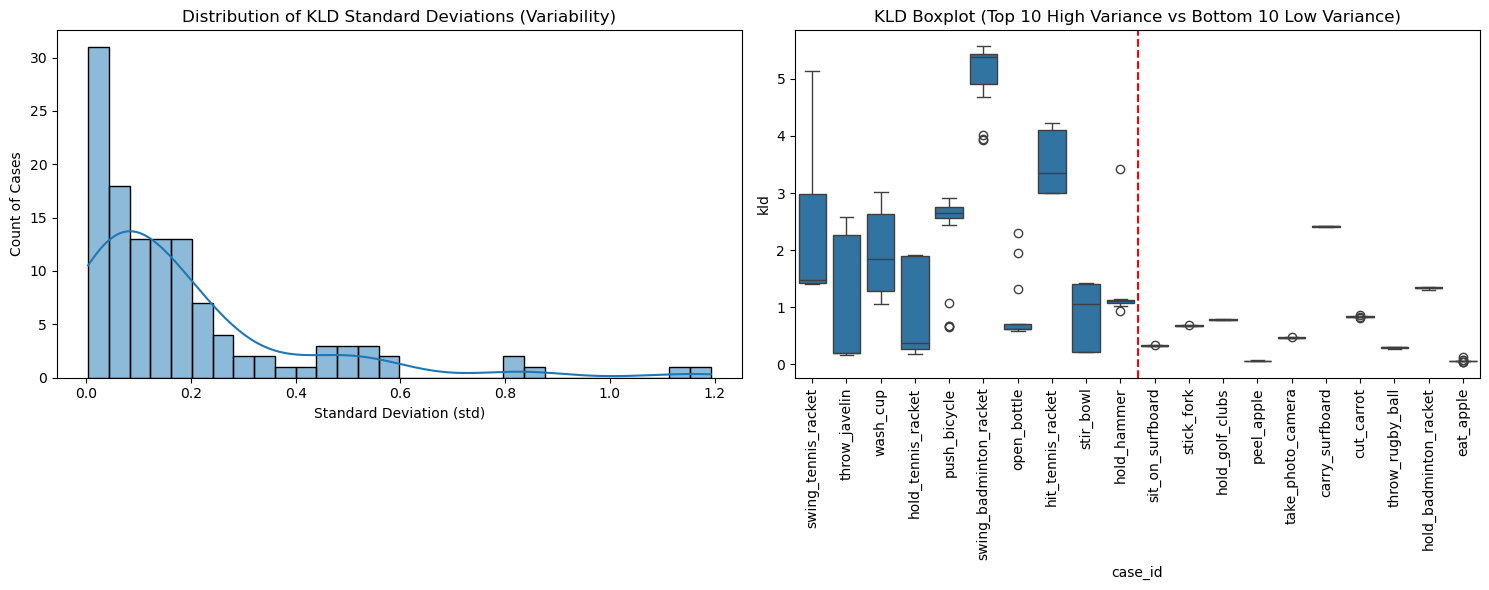

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. case_id 별 통계량 계산 (평균, 표준편차, 최소, 최대)
# std(표준편차)가 바로 데이터의 '편차' 수준을 나타냅니다.
kld_stats = df.groupby('case_id')['kld'].agg(['count', 'mean', 'std', 'min', 'max'])

# 범위(Range)도 추가로 계산 (Max - Min)
kld_stats['range'] = kld_stats['max'] - kld_stats['min']

# 변동계수(CV) 계산: 평균 대비 편차가 얼마나 큰지 (표준편차 / 평균)
kld_stats['cv'] = kld_stats['std'] / kld_stats['mean']

# 결과 출력 (std가 높은 순으로 정렬하여 상위 5개 확인)
print("=== KLD 편차가 큰 상위 5개 Case ===")
print(kld_stats.sort_values(by='std', ascending=False).head(5))

print("\n=== KLD 표준편차(std)의 전체 분포 통계 ===")
print(kld_stats['std'].describe())

# -------------------------------------------------------
# 2. 시각화 분석
# -------------------------------------------------------
plt.figure(figsize=(15, 6))

# (1) 표준편차(std)의 히스토그램
# -> 그래프가 뾰족하면 모든 케이스가 비슷한 편차를 가짐
# -> 그래프가 넓게 퍼져있으면 케이스마다 편차 차이가 큼
plt.subplot(1, 2, 1)
sns.histplot(kld_stats['std'].dropna(), kde=True, bins=30)
plt.title('Distribution of KLD Standard Deviations (Variability)')
plt.xlabel('Standard Deviation (std)')
plt.ylabel('Count of Cases')

# (2) Boxplot: 편차가 가장 큰 10개 vs 가장 작은 10개 비교
# 전체를 다 그리면 너무 많으므로 양극단만 비교합니다.
top_10_var = kld_stats.sort_values(by='std', ascending=False).head(10).index
bottom_10_var = kld_stats.sort_values(by='std', ascending=True).head(10).index
target_cases = list(top_10_var) + list(bottom_10_var)
subset_df = df[df['case_id'].isin(target_cases)]

plt.subplot(1, 2, 2)
sns.boxplot(x='case_id', y='kld', data=subset_df, order=target_cases)
plt.xticks(rotation=90)
plt.title('KLD Boxplot (Top 10 High Variance vs Bottom 10 Low Variance)')
plt.axvline(x=9.5, color='red', linestyle='--') # 구분선

plt.tight_layout()
plt.show()

In [4]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. 설정 및 로드
# ------------------------------------------------
# 저장해둔 피클 파일 로드
df_path = "32B_all_trials_scored.pkl" # 또는 metrics.pkl
df = pd.read_pickle(df_path)

print(f"data size: {len(df)}")
df['ego_path'] = df['ego_path'].str.replace("/root","/home/DATA")
df['exo_path'] = df['exo_path'].str.replace("/root","/home/DATA")
# df

/home/bongo/anaconda3/envs/qwen3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data size: 2156


Loading CLIP: openai/clip-vit-large-patch14...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


🚀 Calculating CLIP Scores...


  0%|          | 0/2156 [00:00<?, ?it/s]/tmp/ipykernel_2485935/3983018700.py:36: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/native/TensorShape.cpp:3683.)
  visual_sim = (img_embeds[0] @ img_embeds[1].T).item() # Cosine Sim
100%|██████████| 2156/2156 [01:47<00:00, 19.99it/s]



📊 Correlation Matrix (High Variance Cases, N=2156)
                     kld  visual_sim  semantic_score
kld             1.000000   -0.118247        0.074584
visual_sim     -0.118247    1.000000        0.272619
semantic_score  0.074584    0.272619        1.000000
✅ Saved clip_analysis.png


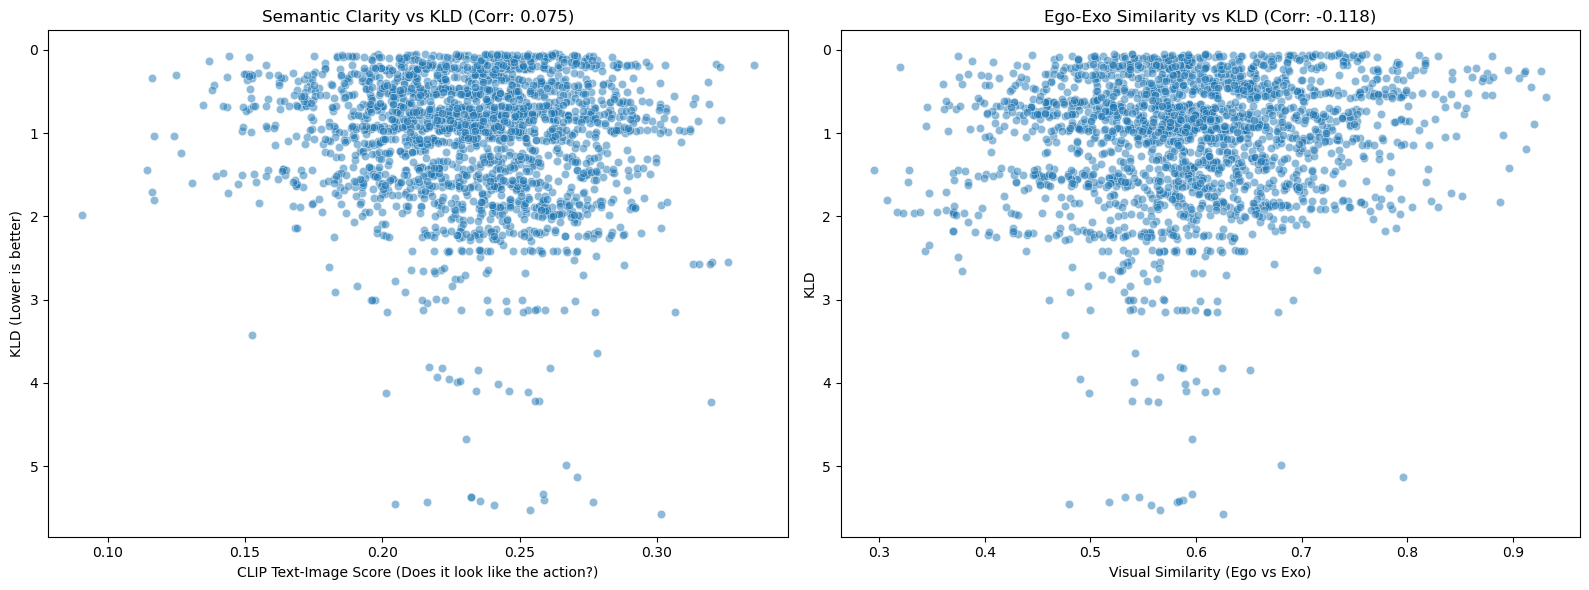

In [5]:


# CLIP 모델 로드 (가볍고 빠른 ViT-B/32 또는 성능 좋은 ViT-L/14 사용)
model_id = "openai/clip-vit-large-patch14" 
print(f"Loading CLIP: {model_id}...")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained(model_id).to(device)
processor = CLIPProcessor.from_pretrained(model_id)
tokenizer = CLIPTokenizer.from_pretrained(model_id)

# ------------------------------------------------
# 2. CLIP Score 계산 함수
# ------------------------------------------------
def get_clip_scores(row):
    try:
        # 이미지 로드
        img_ego = Image.open(row['ego_path']).convert("RGB")
        img_exo = Image.open(row['exo_path']).convert("RGB")
        
        # 텍스트 프롬프트 생성 (예: "A photo of a person holding tennis racket")
        text_prompt = f"A photo of a person {row['action'].replace('_', ' ')} {row['object'].replace('_', ' ')}"
        
        # 입력 처리
        inputs = processor(
            text=[text_prompt], 
            images=[img_ego, img_exo], 
            return_tensors="pt", 
            padding=True
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            
        # 1. Image-Image Similarity (Ego <-> Exo)
        # image_embeds[0]: Ego, image_embeds[1]: Exo
        img_embeds = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
        visual_sim = (img_embeds[0] @ img_embeds[1].T).item() # Cosine Sim
        
        # 2. Text-Image Similarity (Exo <-> Text)
        text_embeds = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)
        # text_embeds[0] vs image_embeds[1] (Exo)
        semantic_score = (text_embeds[0] @ img_embeds[1].T).item()
        
        return visual_sim, semantic_score
        
    except Exception as e:
        print(f"Error: {e}")
        return None, None

# ------------------------------------------------
# 3. 계산 루프
# ------------------------------------------------
tqdm.pandas()
print("🚀 Calculating CLIP Scores...")

# df의 각 행에 대해 점수 계산
results = df.progress_apply(get_clip_scores, axis=1)
df['visual_sim'] = [res[0] for res in results]     # Ego-Exo 유사도
df['semantic_score'] = [res[1] for res in results] # Exo-Text 일치도

# ------------------------------------------------
# 4. 분석 및 시각화 (High Variance 그룹 대상)
# ------------------------------------------------
# 다시 민감한(High Variance) 그룹만 추출
variance_df = df.groupby("case_id")["kld"].std().reset_index()
variance_df.rename(columns={"kld": "kld_std"}, inplace=True)
df_merged = pd.merge(df, variance_df, on="case_id")

threshold = df_merged["kld_std"].quantile(0.7) # 상위 30%
sensitive_df = df_merged.copy()# [df_merged["kld_std"] >= threshold].copy()

print(f"\n📊 Correlation Matrix (High Variance Cases, N={len(sensitive_df)})")
cols = ['kld', 'visual_sim', 'semantic_score']
corr_mat = sensitive_df[cols].corr()
print(corr_mat)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# (1) Semantic Score vs KLD (기대: 우하향)
sns.scatterplot(data=sensitive_df, x='semantic_score', y='kld', alpha=0.5, ax=ax[0])
ax[0].set_title(f"Semantic Clarity vs KLD (Corr: {corr_mat.loc['kld','semantic_score']:.3f})")
ax[0].set_xlabel("CLIP Text-Image Score (Does it look like the action?)")
ax[0].set_ylabel("KLD (Lower is better)")
ax[0].invert_yaxis()

# (2) Visual Similarity vs KLD (기대: U-Shape 혹은 특정 구간)
sns.scatterplot(data=sensitive_df, x='visual_sim', y='kld', alpha=0.5, ax=ax[1])
ax[1].set_title(f"Ego-Exo Similarity vs KLD (Corr: {corr_mat.loc['kld','visual_sim']:.3f})")
ax[1].set_xlabel("Visual Similarity (Ego vs Exo)")
ax[1].set_ylabel("KLD")
ax[1].invert_yaxis()

plt.tight_layout()
plt.savefig("clip_analysis.png")
print("✅ Saved clip_analysis.png")

📊 Correlation with KLD (Lower KLD is better, so Negative Corr is good)
visual_sim     -0.118247
mix_safety     -0.046031
mix_balanced    0.007795
mix_mult        0.040604
attn_score      0.069009
kld             1.000000
Name: kld, dtype: float64


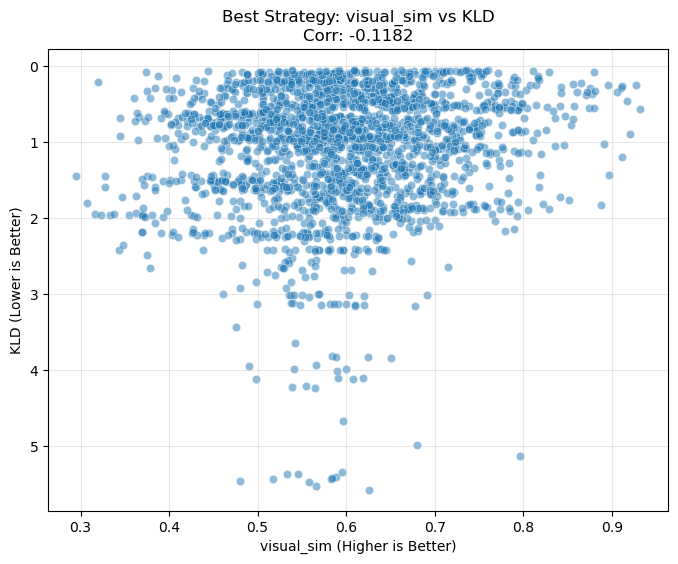

----------------------------------------
🎯 Simulation Result (High Variance Cases)
   Random Selection Mean KLD : 1.0765
   visual_sim Selection Mean KLD: 1.1145
   Gain: -0.0380


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. 데이터 준비 (이미 메모리에 df, sensitive_df가 있다고 가정)
#    없다면 이전 단계의 sensitive_df를 사용합니다.
# ------------------------------------------------

# 데이터 복사 (원본 보존)
target_df = sensitive_df.copy()

# ------------------------------------------------
# 2. 정규화 (Normalization) - 스케일 맞추기
# ------------------------------------------------
# Min-Max Scaling (0~1 사이로 변환)
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

target_df['norm_sim'] = normalize(target_df['visual_sim'])
target_df['norm_attn'] = normalize(target_df['attn_score'])

# ------------------------------------------------
# 3. 조합 지표 생성 (Mixing Strategies)
# ------------------------------------------------

# (A) Balanced Mix (50:50 가중치)
# -> "Ego랑 비슷하면서도(안전), 모델이 동사를 잘 뱉는(정보) 이미지"
target_df['mix_balanced'] = target_df['norm_sim'] + target_df['norm_attn']

# (B) Safety First (Sim 가중치 70%)
# -> "일단 비슷한 게 최고인데, 그 중에서 말 좀 하는 놈"
target_df['mix_safety'] = (target_df['norm_sim'] * 0.7) + (target_df['norm_attn'] * 0.3)

# (C) Multiplicative (곱셈)
# -> 둘 중 하나라도 0(나쁨)이면 점수를 확 깎음
target_df['mix_mult'] = target_df['norm_sim'] * target_df['norm_attn']

# ------------------------------------------------
# 4. 상관관계 확인
# ------------------------------------------------
check_cols = ['kld', 'visual_sim', 'attn_score', 'mix_balanced', 'mix_safety', 'mix_mult']
corr_mat = target_df[check_cols].corr()

print("📊 Correlation with KLD (Lower KLD is better, so Negative Corr is good)")
print(corr_mat['kld'].sort_values())

# ------------------------------------------------
# 5. 시각화 (가장 좋은 조합에 대해)
# ------------------------------------------------
best_metric = corr_mat['kld'].idxmin() # 가장 음수(좋은 상관관계)인 지표 찾기
corr_val = corr_mat.loc['kld', best_metric]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=target_df, x=best_metric, y='kld', alpha=0.5)
plt.title(f"Best Strategy: {best_metric} vs KLD\nCorr: {corr_val:.4f}")
plt.xlabel(f"{best_metric} (Higher is Better)")
plt.ylabel("KLD (Lower is Better)")
plt.gca().invert_yaxis() # 우상향 그래프가 나오는지 확인
plt.grid(True, alpha=0.3)
plt.show()

# (Optional) Top-1 Selection Simulation
# 각 케이스별로 이 점수가 가장 높은 이미지를 뽑았을 때, 평균 KLD가 얼마가 되는지 시뮬레이션
best_kld_mean = target_df.loc[target_df.groupby("case_id")[best_metric].idxmax()]['kld'].mean()
random_kld_mean = target_df['kld'].mean()

print("-" * 40)
print(f"🎯 Simulation Result (High Variance Cases)")
print(f"   Random Selection Mean KLD : {random_kld_mean:.4f}")
print(f"   {best_metric} Selection Mean KLD: {best_kld_mean:.4f}")
print(f"   Gain: {random_kld_mean - best_kld_mean:.4f}")

In [7]:
import pandas as pd
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel

# -------------------------------------------------------
# 1. Visual Sim 단독 성능 검증 (vs Random)
# -------------------------------------------------------
print("🥊 Round 1: 'Most Similar' vs 'Random'")

# 각 Case 별로 Visual Sim이 가장 높은 이미지의 KLD
sim_best_kld = sensitive_df.loc[sensitive_df.groupby("case_id")["visual_sim"].idxmax()]["kld"].mean()

# Random (전체 평균)
random_kld = sensitive_df["kld"].mean()

print(f"   Random Selection KLD : {random_kld:.4f}")
print(f"   Max Sim Selection KLD: {sim_best_kld:.4f}")
print(f"   🚀 Gain: {random_kld - sim_best_kld:.4f}")

# -------------------------------------------------------
# 2. 새로운 가설: Object Visibility (CLIP Object Score)
# -------------------------------------------------------
print("\n🔍 Round 2: Checking 'Object Clarity' Correlation...")

# CLIP 모델 로드 (없으면 로드)
if 'model' not in locals():
    model_id = "openai/clip-vit-large-patch14"
    model = CLIPModel.from_pretrained(model_id).to("cuda")
    processor = CLIPProcessor.from_pretrained(model_id)

def get_object_score(row):
    try:
        # 텍스트: 행동 빼고 "물체"만 입력
        text_prompt = f"A photo of a {row['object'].replace('_', ' ')}"
        # 이미지는 경로에서 로드 필요 (생략시 row에 이미지 객체가 있다고 가정하거나 다시 로드)
        from PIL import Image
        image = Image.open(row['exo_path']).convert("RGB")
        
        inputs = processor(text=[text_prompt], images=image, return_tensors="pt", padding=True).to("cuda")
        
        with torch.no_grad():
            outputs = model(**inputs)
            # Image-Text Similarity
            logits_per_image = outputs.logits_per_image  # this is the similarity score
            return logits_per_image.item()
    except:
        return None

# tqdm 적용
from tqdm import tqdm
tqdm.pandas()

# 이미 계산된 데이터가 없다면 계산 (시간 절약을 위해 일부만 테스트 가능)
sensitive_df['object_score'] = sensitive_df.progress_apply(get_object_score, axis=1)

# (이미지가 없어서 계산이 오래 걸린다면, 로직만 확인하세요. 
# 만약 가능하다면 아래 상관관계만 확인)

# 가상 코드 (계산되었다고 가정 시)
corr = sensitive_df[['kld', 'object_score', 'visual_sim']].corr()
print(corr['kld'])

🥊 Round 1: 'Most Similar' vs 'Random'
   Random Selection KLD : 1.0765
   Max Sim Selection KLD: 1.1145
   🚀 Gain: -0.0380

🔍 Round 2: Checking 'Object Clarity' Correlation...


100%|██████████| 2156/2156 [00:53<00:00, 40.47it/s]

kld             1.000000
object_score    0.150892
visual_sim     -0.118247
Name: kld, dtype: float64


📊 Correlation with KLD (Target: Lower than -0.125)
mix_sub        -0.217812
visual_sim     -0.118247
mix_weighted    0.020037
mix_add         0.020037
object_score    0.150892
kld             1.000000
Name: kld, dtype: float64


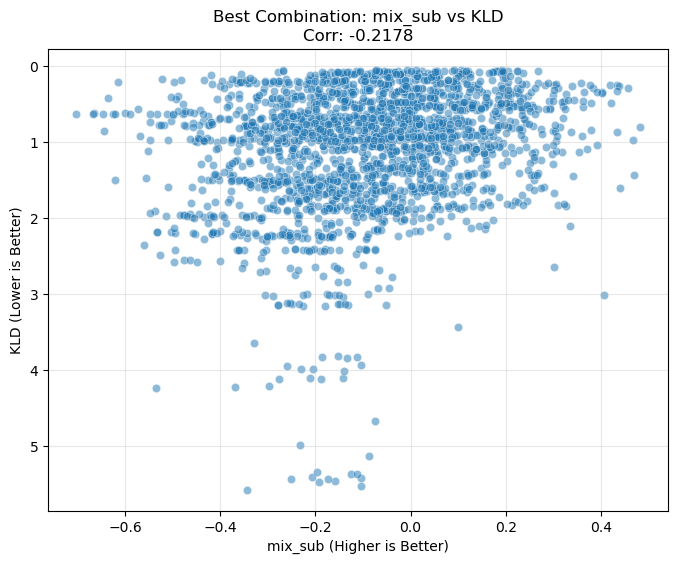

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 준비 (sensitive_df가 있다고 가정)
# sensitive_df = ... 

# ------------------------------------------------
# 1. 정규화 (Normalization)
# ------------------------------------------------
# 두 지표의 단위(Scale)가 다르므로 0~1로 맞춥니다.
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

sensitive_df['norm_sim'] = normalize(sensitive_df['visual_sim'])
sensitive_df['norm_obj'] = normalize(sensitive_df['object_score'])

# ------------------------------------------------
# 2. 조합 지표 생성 (Mixing)
# ------------------------------------------------

# (A) Naive Add (단순 합산) -> 서로 상쇄될 것으로 예상됨
sensitive_df['mix_add'] = sensitive_df['norm_sim'] + sensitive_df['norm_obj']

# (B) Subtraction (빼기 전략) -> "유사도는 높되, 너무 제품 사진 같은 건 제외"
# Sim은 높을수록 좋고(Low KLD), Object는 높을수록 나쁘니(High KLD),
# Sim - Object를 하면 "Context는 풍부하고 물체 강박은 적은" 이미지가 됨
sensitive_df['mix_sub'] = sensitive_df['norm_sim'] - sensitive_df['norm_obj']

# (C) Sim Weighted (Sim 몰빵 + Object 조금)
sensitive_df['mix_weighted'] = (sensitive_df['norm_sim'] * 0.5) + (sensitive_df['norm_obj'] * 0.5)

# ------------------------------------------------
# 3. 상관관계 확인
# ------------------------------------------------
cols = ['kld', 'visual_sim', 'object_score', 'mix_add', 'mix_sub', 'mix_weighted']
corr_mat = sensitive_df[cols].corr()

print("📊 Correlation with KLD (Target: Lower than -0.125)")
print(corr_mat['kld'].sort_values())

# ------------------------------------------------
# 4. 시각화 (가장 좋은 지표에 대해)
# ------------------------------------------------
# 가장 강력한 음의 상관관계(Negative Corr)를 가진 지표 찾기
best_metric = corr_mat['kld'].idxmin()
best_corr = corr_mat.loc['kld', best_metric]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=sensitive_df, x=best_metric, y='kld', alpha=0.5)
plt.title(f"Best Combination: {best_metric} vs KLD\nCorr: {best_corr:.4f}")
plt.xlabel(f"{best_metric} (Higher is Better)")
plt.ylabel("KLD (Lower is Better)")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.show()

📁 Analyzing 2156 rows (Full Dataset)...

🏁 Final Performance Simulation (Lower KLD is Better)
1. Random Selection   : 1.0632
2. Visual Sim Only    : 1.1145
3. Mix Sub (Sim-Obj)  : 1.0251  <-- 🔥 NEW BEST?
----------------------------------------
🚀 Gain vs Random : 0.0382
✨ Gain vs Sim    : 0.0894


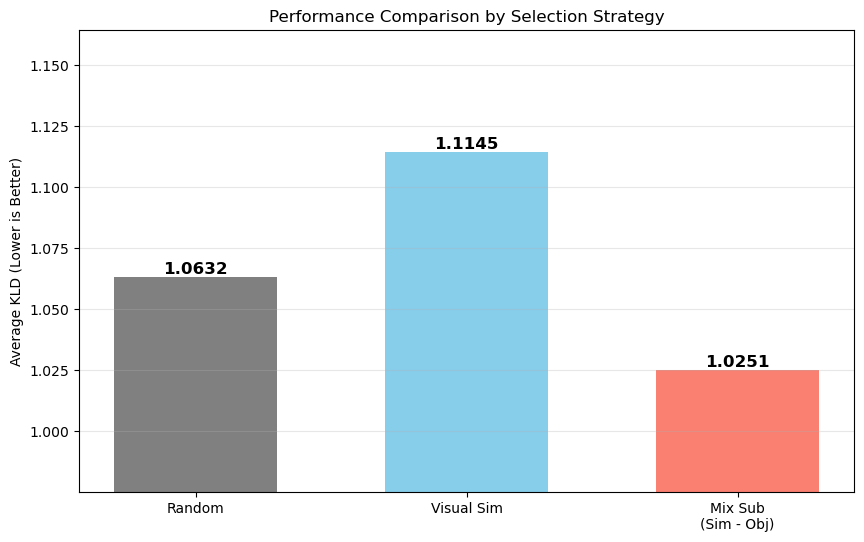

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------
# 1. 데이터 준비 (전체 데이터 로드)
# -------------------------------------------------------
# sensitive_df가 아니라 전체 df를 사용해야 합니다.
# 만약 df가 메모리에 없다면 다시 로드하세요.
# df = pd.read_pickle("path/to/2B_all_trials_scored.pkl") # 또는 metrics pkl + object score 추가된 df

# 혹시 object_score가 계산 안 된 행이 있다면 제거 (안전장치)
df_clean = sensitive_df.dropna(subset=['visual_sim', 'object_score', 'kld']).copy()

print(f"📁 Analyzing {len(df_clean)} rows (Full Dataset)...")

# -------------------------------------------------------
# 2. 정규화 및 지표 계산 (전체 데이터 기준)
# -------------------------------------------------------
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

df_clean['norm_sim'] = normalize(df_clean['visual_sim'])
df_clean['norm_obj'] = normalize(df_clean['object_score'])

# 🏆 Winning Metric: Mix Sub
df_clean['mix_sub'] = df_clean['norm_sim'] - df_clean['norm_obj']

# -------------------------------------------------------
# 3. 전략별 Top-1 선택 시뮬레이션
# -------------------------------------------------------
# 각 case_id 별로 특정 지표가 가장 높은 행(Row)을 뽑습니다.

# (1) Visual Sim Only Strategy
idx_best_sim = df_clean.groupby('case_id')['visual_sim'].idxmax()
sim_selection = df_clean.loc[idx_best_sim]

# (2) Mix Sub Strategy (New!)
idx_best_mix = df_clean.groupby('case_id')['mix_sub'].idxmax()
mix_selection = df_clean.loc[idx_best_mix]

# (3) Random (평균값 사용)
random_kld_mean = df_clean.groupby('case_id')['kld'].mean().mean() # Case별 평균의 평균

# -------------------------------------------------------
# 4. 결과 비교 및 출력
# -------------------------------------------------------
mean_kld_sim = sim_selection['kld'].mean()
mean_kld_mix = mix_selection['kld'].mean()

print("\n" + "="*40)
print("🏁 Final Performance Simulation (Lower KLD is Better)")
print("="*40)
print(f"1. Random Selection   : {random_kld_mean:.4f}")
print(f"2. Visual Sim Only    : {mean_kld_sim:.4f}")
print(f"3. Mix Sub (Sim-Obj)  : {mean_kld_mix:.4f}  <-- 🔥 NEW BEST?")
print("-" * 40)

# Gain 계산
gain_vs_random = random_kld_mean - mean_kld_mix
gain_vs_sim = mean_kld_sim - mean_kld_mix

print(f"🚀 Gain vs Random : {gain_vs_random:.4f}")
print(f"✨ Gain vs Sim    : {gain_vs_sim:.4f}")

# -------------------------------------------------------
# 5. 시각화 (Performance Bar Chart)
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
methods = ['Random', 'Visual Sim', 'Mix Sub\n(Sim - Obj)']
scores = [random_kld_mean, mean_kld_sim, mean_kld_mix]
colors = ['gray', 'skyblue', 'salmon']

bars = plt.bar(methods, scores, color=colors, width=0.6)

# 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(min(scores) - 0.05, max(scores) + 0.05) # 그래프 y축 조정
plt.ylabel("Average KLD (Lower is Better)")
plt.title("Performance Comparison by Selection Strategy")
plt.grid(axis='y', alpha=0.3)
plt.savefig("final_performance_comparison.png")
plt.show()

In [10]:
# ------------------------------------------------
# (3) Random (Case별 1개 무작위 추출 시뮬레이션)
# ------------------------------------------------
# 재현성을 위해 random_state를 고정합니다 (예: 42)
# 각 case_id 그룹에서 1개의 행(Row)만 랜덤 샘플링
random_selection_df = df_clean.groupby('case_id').sample(n=1, random_state=41)

# 뽑힌 샘플들의 KLD 평균 계산
random_kld_mean = random_selection_df['kld'].mean()
random_sim_mean = random_selection_df['sim'].mean()
random_nss_mean = random_selection_df['nss'].mean()

print(f"🎲 Simulated Random Selection Mean KLD: {random_kld_mean:.4f}, SIM : {random_sim_mean:.4f}, NSS : {random_nss_mean:.4f}")

🎲 Simulated Random Selection Mean KLD: 1.0322, SIM : 0.4649, NSS : 1.3480


In [ ]:
case_id action object exo_path

In [26]:
random_selection_df.to_pickle("both_random_exo.pkl")
random_selection_df

,case_id,action,object,ego_image,exo_image,ego_path,exo_path,kld,sim,nss,...,has_action_text,visual_sim,semantic_score,kld_std,object_score,norm_sim,norm_obj,mix_add,mix_sub,mix_weighted
1886,beat_drum,beat,drum,drum_002586.jpg,beat_drum_011271.jpg,/home/DATA/AGD20K/Seen/testset/egocentric/beat...,/home/DATA/AGD20K/Seen/trainset/exocentric/bea...,0.181631,0.770214,0.971556,...,Y,0.742590,0.247843,0.420694,23.854137,0.702761,0.727679,1.430440,-0.024919,0.715220
827,boxing_punching_bag,boxing,punching_bag,punching_bag_001845.jpg,boxing_punching_bag_014056.jpg,/home/DATA/AGD20K/Seen/testset/egocentric/boxi...,/home/DATA/AGD20K/Seen/trainset/exocentric/box...,0.458363,0.620384,0.584083,...,Y,0.630231,0.237054,0.018883,23.407900,0.526262,0.706738,1.233000,-0.180476,0.616500
1750,brush_with_toothbrush,brush_with,toothbrush,toothbrush_001764.jpg,brush_with_toothbrush_008144.jpg,/home/DATA/AGD20K/Seen/testset/egocentric/brus...,/home/DATA/AGD20K/Seen/trainset/exocentric/bru...,1.595047,0.243454,1.946775,...,Y,0.634934,0.254639,0.300733,22.241697,0.533649,0.652009,1.185658,-0.118359,0.592829
1168,carry_skateboard,carry,skateboard,skateboard_002668.jpg,carry_skateboard_008002.jpg,/home/DATA/AGD20K/Seen/testset/egocentric/carr...,/home/DATA/AGD20K/Seen/trainset/exocentric/car...,0.225907,0.748139,0.792934,...,Y,0.558058,0.237928,0.081777,24.372160,0.412890,0.751990,1.164880,-0.339100,0.582440
1143,carry_skis,carry,skis,skis_002829.jpg,carry_skis_002194.jpg,/home/DATA/AGD20K/Seen/testset/egocentric/carr...,/home/DATA/AGD20K/Seen/trainset/exocentric/car...,3.148441,0.075272,-0.238326,...,Y,0.677491,0.306654,0.502551,24.993582,0.600501,0.781153,1.381654,-0.180651,0.690827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,wash_knife,wash,knife,knife_002720.jpg,wash_knife_008581.jpg,/home/DATA/AGD20K/Seen/testset/egocentric/wash...,/home/DATA/AGD20K/Seen/trainset/exocentric/was...,0.963952,0.419111,2.775346,...,Y,0.592179,0.221174,0.267535,21.195686,0.466488,0.602920,1.069408,-0.136433,0.534704
145,wash_orange,wash,orange,orange_001193.jpg,wash_orange_005878.jpg,/home/DATA/AGD20K/Seen/testset/egocentric/wash...,/home/DATA/AGD20K/Seen/trainset/exocentric/was...,0.574794,0.657457,1.220016,...,Y,0.560827,0.313699,0.037877,26.685291,0.417238,0.860543,1.277782,-0.443305,0.638891
131,wash_toothbrush,wash,toothbrush,toothbrush_001991.jpg,wash_toothbrush_006501.jpg,/home/DATA/AGD20K/Seen/testset/egocentric/wash...,/home/DATA/AGD20K/Seen/trainset/exocentric/was...,0.996091,0.388586,3.057469,...,Y,0.571189,0.269962,0.235939,25.631323,0.433516,0.811081,1.244598,-0.377565,0.622299
152,wash_wine_glass,wash,wine_glass,wine_glass_000186.jpg,wash_wine_glass_013676.jpg,/home/DATA/AGD20K/Seen/testset/egocentric/wash...,/home/DATA/AGD20K/Seen/trainset/exocentric/was...,0.729270,0.496286,1.724283,...,Y,0.672523,0.261961,0.142358,24.449562,0.592696,0.755622,1.348318,-0.162926,0.674159



🏁 Final Ablation Study (KLD: Lower is Better)
1. Random Baseline      : 1.0632
2. Current Best (Sub)   : 1.0251
3. Challenger (+0.1 Att): 1.0459
--------------------------------------------------
📉 Slightly worse by -0.02089 (Noise added?)


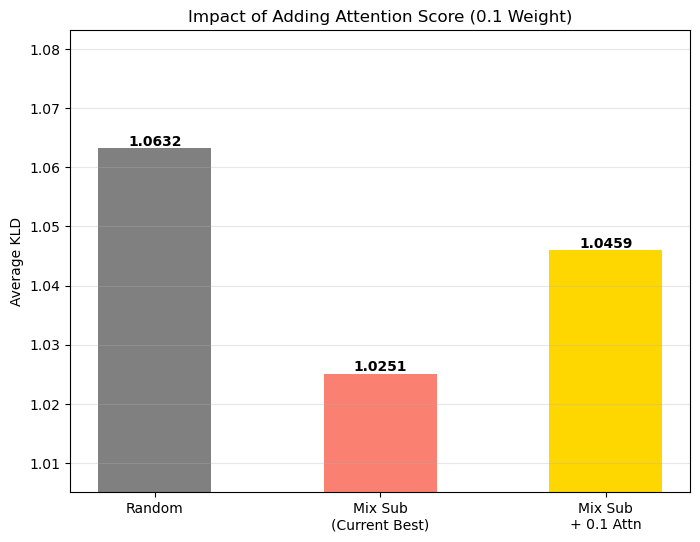

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. 데이터 준비 (전체 데이터)
# -------------------------------------------------------
# df_clean이 메모리에 있다고 가정 (없으면 로드)
# df_clean = pd.read_pickle("...") 

# -------------------------------------------------------
# 2. 정규화 (Normalization)
# -------------------------------------------------------
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

df_clean['norm_sim'] = normalize(df_clean['visual_sim'])
df_clean['norm_obj'] = normalize(df_clean['object_score'])
df_clean['norm_attn'] = normalize(df_clean['attn_score'])

# -------------------------------------------------------
# 3. 전략 정의 (Challenger vs Champion)
# -------------------------------------------------------

# 🏆 Current Champion: Context-Aware (Sim - Obj)
df_clean['score_champion'] = df_clean['norm_sim'] - df_clean['norm_obj']

# 🥊 Challenger: Champion + 0.1 * Attention
# "문맥도 좋고 물체 강박도 없는데, 기왕이면 모델이 말 좀 많이 한 거"
df_clean['score_challenger'] = (df_clean['norm_sim'] - df_clean['norm_obj']) + (0.1 * df_clean['norm_attn'])

# -------------------------------------------------------
# 4. 성능 시뮬레이션
# -------------------------------------------------------

# (1) Random Baseline
random_kld = df_clean.groupby('case_id')['kld'].mean().mean()

# (2) Champion Selection (Sim - Obj)
idx_champ = df_clean.groupby('case_id')['score_champion'].idxmax()
kld_champion = df_clean.loc[idx_champ]['kld'].mean()

# (3) Challenger Selection (Sim - Obj + 0.1 Attn)
idx_chall = df_clean.groupby('case_id')['score_challenger'].idxmax()
kld_challenger = df_clean.loc[idx_chall]['kld'].mean()

# -------------------------------------------------------
# 5. 결과 출력
# -------------------------------------------------------
print("\n" + "="*50)
print("🏁 Final Ablation Study (KLD: Lower is Better)")
print("="*50)
print(f"1. Random Baseline      : {random_kld:.4f}")
print(f"2. Current Best (Sub)   : {kld_champion:.4f}")
print(f"3. Challenger (+0.1 Att): {kld_challenger:.4f}")
print("-" * 50)

gain = kld_champion - kld_challenger
if gain > 0:
    print(f"🎉 Success! Improved by {gain:.5f}")
else:
    print(f"📉 Slightly worse by {gain:.5f} (Noise added?)")

# -------------------------------------------------------
# 6. 시각화
# -------------------------------------------------------
plt.figure(figsize=(8, 6))
methods = ['Random', 'Mix Sub\n(Current Best)', 'Mix Sub\n+ 0.1 Attn']
scores = [random_kld, kld_champion, kld_challenger]
colors = ['gray', 'salmon', 'gold']

bars = plt.bar(methods, scores, color=colors, width=0.5)

# Y축 범위 조정 (차이를 극대화해서 보기 위해)
plt.ylim(min(scores) - 0.02, max(scores) + 0.02)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', 
             ha='center', va='bottom', fontweight='bold')

plt.title("Impact of Adding Attention Score (0.1 Weight)")
plt.ylabel("Average KLD")
plt.grid(axis='y', alpha=0.3)
plt.show()

In [12]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import numpy as np
from tqdm import tqdm

# ------------------------------------------------
# 1. 설정 및 모델 로드
# ------------------------------------------------
# df = pd.read_pickle("...") # 데이터 로드 (sensitive_df 권장)

if 'model' not in locals():
    model_id = "openai/clip-vit-large-patch14"
    model = CLIPModel.from_pretrained(model_id).to("cuda")
    processor = CLIPProcessor.from_pretrained(model_id)

# ------------------------------------------------
# 2. 새로운 Score 계산 함수
# ------------------------------------------------
def get_additional_scores(row):
    try:
        # 이미지 로드 (경로 주의)
        image = Image.open(row['exo_path']).convert("RGB")
        
        # 텍스트 프롬프트 정의
        obj_text = f"A photo of a {row['object'].replace('_', ' ')}"
        action_text = f"A photo of a person {row['action'].replace('_', ' ')} {row['object'].replace('_', ' ')}"
        hand_text = f"A photo of hands interacting with {row['object'].replace('_', ' ')}"
        using_text = f"A photo of a person using {row['object'].replace('_', ' ')}"
        
        texts = [obj_text, action_text, hand_text, using_text]
        
        inputs = processor(text=texts, images=image, return_tensors="pt", padding=True).to("cuda")
        
        with torch.no_grad():
            outputs = model(**inputs)
            # Logits: [1, 4] (Image vs 4 Texts)
            logits = outputs.logits_per_image.squeeze(0) # shape: [4]
            
            s_obj = logits[0].item()
            s_action = logits[1].item()
            s_hand = logits[2].item()
            s_using = logits[3].item()
            
            return s_obj, s_action, s_hand, s_using
    except Exception as e:
        print(e)
        return None, None, None, None

# ------------------------------------------------
# 3. 계산 실행
# ------------------------------------------------
tqdm.pandas()
print("🚀 Calculating New Hypothesis Scores...")
# 시간 절약을 위해 sensitive_df(High Variance 그룹)에만 먼저 돌려보는 것을 추천
results = sensitive_df.progress_apply(get_additional_scores, axis=1)

sensitive_df['raw_obj'] = [r[0] for r in results]
sensitive_df['raw_action'] = [r[1] for r in results]
sensitive_df['raw_hand'] = [r[2] for r in results]
sensitive_df['raw_using'] = [r[3] for r in results]

# ------------------------------------------------
# 4. 정규화 및 파생 지표 생성
# ------------------------------------------------
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# 정규화
sensitive_df['norm_obj'] = normalize(sensitive_df['raw_obj']) # 기존 object_score와 동일해야 함
sensitive_df['norm_action'] = normalize(sensitive_df['raw_action'])
sensitive_df['norm_hand'] = normalize(sensitive_df['raw_hand'])
sensitive_df['norm_using'] = normalize(sensitive_df['raw_using'])

# 🔥 가설 지표 생성
# H1: Action Delta (동사가 들어갔을 때 점수 상승폭)
sensitive_df['hyp_delta'] = sensitive_df['norm_action'] - sensitive_df['norm_obj']

# H2: Hand Presence (손이 있는가)
sensitive_df['hyp_hand'] = sensitive_df['norm_hand']

# H3: Using (사용 중인가) -> H1과 비슷할 수 있음
sensitive_df['hyp_using'] = sensitive_df['norm_using']

# 🏆 기존 Best (Mix Sub)
sensitive_df['mix_sub'] = sensitive_df['norm_sim'] - sensitive_df['norm_obj']

# 🚀 New Challenger: Mix Sub + Hand
# "Ego랑 비슷하고(Sim), 물체만 있지 않고(Obj), 손이 보여야 한다(Hand)"
sensitive_df['mix_sub_hand'] = sensitive_df['mix_sub'] + sensitive_df['norm_hand']

# ------------------------------------------------
# 5. 상관관계 확인
# ------------------------------------------------
target_cols = ['kld', 'mix_sub', 'hyp_delta', 'hyp_hand', 'hyp_using', 'mix_sub_hand']
corr = sensitive_df[target_cols].corr()

print("\n📊 Correlation with KLD (Target: Lower than Mix Sub's corr)")
print(corr['kld'].sort_values())

🚀 Calculating New Hypothesis Scores...


100%|██████████| 2156/2156 [01:08<00:00, 31.43it/s]


📊 Correlation with KLD (Target: Lower than Mix Sub's corr)
mix_sub        -0.217812
mix_sub_hand   -0.151648
hyp_delta      -0.150350
hyp_hand        0.088231
hyp_using       0.123002
kld             1.000000
Name: kld, dtype: float64


In [13]:
# 🚀 New Challenger: Mix Sub + Hand
# "Ego랑 비슷하고(Sim), 물체만 있지 않고(Obj), 손이 보여야 한다(Hand)"
sensitive_df['mix_sub_hand'] = sensitive_df['mix_sub'] - sensitive_df['norm_hand']

# ------------------------------------------------
# 5. 상관관계 확인
# ------------------------------------------------
target_cols = ['kld', 'mix_sub', 'hyp_delta', 'hyp_hand', 'hyp_using', 'mix_sub_hand']
corr = sensitive_df[target_cols].corr()

print("\n📊 Correlation with KLD (Target: Lower than Mix Sub's corr)")
print(corr['kld'].sort_values())


📊 Correlation with KLD (Target: Lower than Mix Sub's corr)
mix_sub        -0.217812
mix_sub_hand   -0.193273
hyp_delta      -0.150350
hyp_hand        0.088231
hyp_using       0.123002
kld             1.000000
Name: kld, dtype: float64


🦖 Loading GroundingDINO...
final text_encoder_type: bert-base-uncased


🚀 Calculating Resolution & Object Scale with GroundingDINO...


100%|██████████| 2156/2156 [04:07<00:00,  8.70it/s]



📊 Correlation with KLD (Aim for Negative Corr)
mix_sub          -0.221679
obj_scale        -0.025514
img_resolution    0.128600
kld               1.000000
Name: kld, dtype: float64


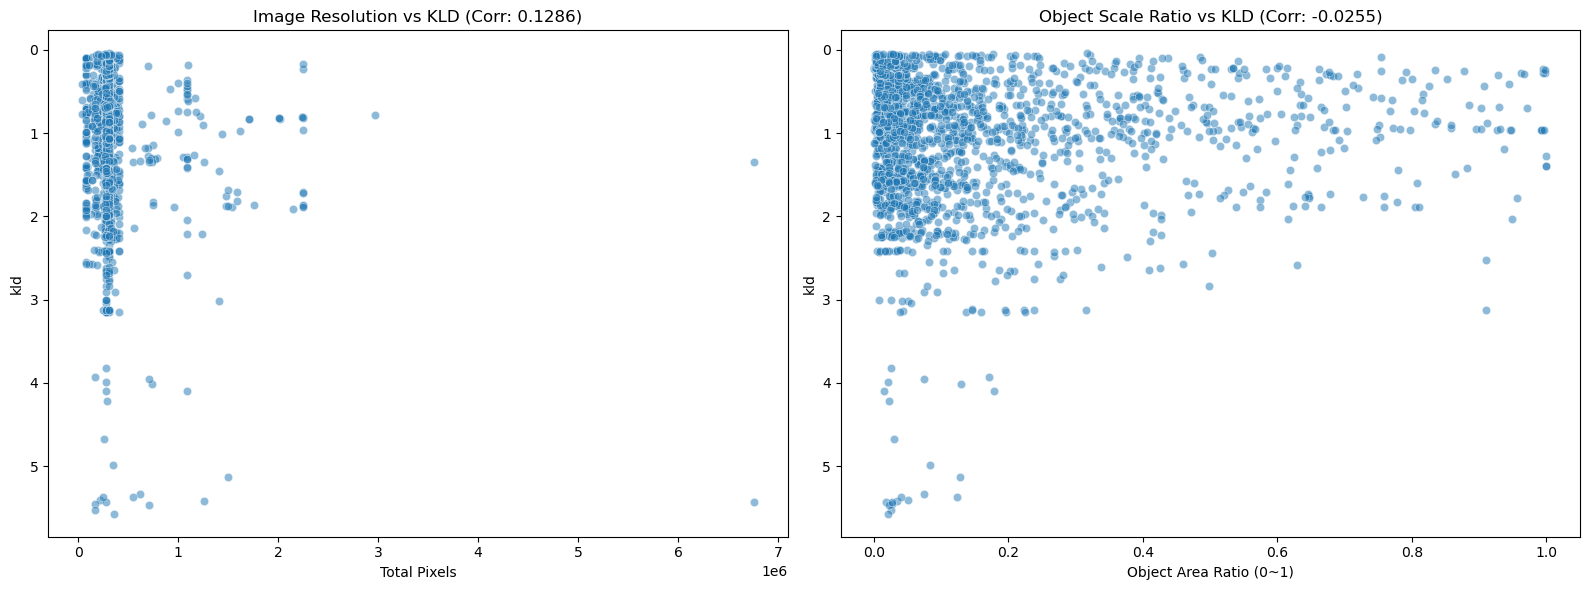

In [14]:
import torch
import cv2
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# GroundingDINO 라이브러리 임포트 (경로가 잡혀있어야 함)
sys.path.append("/home/bongo/porter_notebook/research/GroundingDINO") # 필요시 경로 추가
from groundingdino.util.inference import load_model, load_image, predict

# ------------------------------------------------
# 1. 모델 설정 (사용자 경로 반영)
# ------------------------------------------------
CONFIG_PATH = "/home/bongo/porter_notebook/research/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
# WEIGHT_PATH는 가지고 계신 .pth 파일 경로로 수정해주세요 (예: swin_b 파일)
WEIGHT_PATH = "/home/bongo/porter_notebook/research/GroundingDINO/weights/groundingdino_swint_ogc.pth" 

print("🦖 Loading GroundingDINO...")
model = load_model(CONFIG_PATH, WEIGHT_PATH)

# ------------------------------------------------
# 2. 통계 계산 함수 (GroundingDINO 활용)
# ------------------------------------------------
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25

def get_dino_stats(row):
    try:
        image_path = row['exo_path']
        
        # 1. 이미지 로드 (GroundingDINO 방식)
        image_source, image = load_image(image_path)
        
        # 2. 텍스트 프롬프트 생성 (예: "tennis racket")
        target_object = row['object'].replace('_', ' ')
        text_prompt = target_object # 점(.)은 predict 내부에서 처리되기도 하지만, 안전하게 그냥 단어만
        
        # 3. 예측 (Predict)
        boxes, logits, phrases = predict(
            model=model,
            image=image,
            caption=text_prompt,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD
        )
        
        # 4. 결과 처리
        h, w, _ = image_source.shape
        img_resolution = w * h
        
        if len(boxes) == 0:
            return img_resolution, 0.0
            
        # 가장 높은 점수(Logit)를 가진 박스 선택
        best_idx = torch.argmax(logits).item()
        best_box = boxes[best_idx] # [cx, cy, w, h] (Normalized 0~1)
        
        # GroundingDINO의 box 출력은 [cx, cy, w, h] 형식이며 0~1로 정규화되어 있음
        # 따라서 면적 비율은 w * h 그대로 쓰면 됨! (좌표 변환 불필요)
        box_ratio = best_box[2].item() * best_box[3].item()
        
        return img_resolution, box_ratio

    except Exception as e:
        print(f"Error on {row['exo_path']}: {e}")
        return None, None

# ------------------------------------------------
# 3. 계산 실행
# ------------------------------------------------
tqdm.pandas()
print("🚀 Calculating Resolution & Object Scale with GroundingDINO...")

# sensitive_df 또는 전체 df 사용
target_df = sensitive_df.copy()

results = target_df.progress_apply(get_dino_stats, axis=1)

target_df['img_resolution'] = [r[0] if r else 0 for r in results]
target_df['obj_scale'] = [r[1] if r else 0.0 for r in results]

# ------------------------------------------------
# 4. 결과 분석 (상관관계)
# ------------------------------------------------
# 유효한 데이터만 (탐지 성공한 것들)
valid_df = target_df[target_df['obj_scale'] > 0]

cols = ['kld', 'img_resolution', 'obj_scale', 'mix_sub'] 
corr = valid_df[cols].corr()

print("\n📊 Correlation with KLD (Aim for Negative Corr)")
print(corr['kld'].sort_values())

# ------------------------------------------------
# 5. 시각화
# ------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# (1) Resolution vs KLD
sns.scatterplot(data=valid_df, x='img_resolution', y='kld', alpha=0.5, ax=ax[0])
ax[0].set_title(f"Image Resolution vs KLD (Corr: {corr.loc['kld', 'img_resolution']:.4f})")
ax[0].set_xlabel("Total Pixels")
ax[0].invert_yaxis() 

# (2) Object Scale vs KLD
sns.scatterplot(data=valid_df, x='obj_scale', y='kld', alpha=0.5, ax=ax[1])
ax[1].set_title(f"Object Scale Ratio vs KLD (Corr: {corr.loc['kld', 'obj_scale']:.4f})")
ax[1].set_xlabel("Object Area Ratio (0~1)")
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

📊 Correlation with KLD (Target: Lower than -0.22)
mix_res            -0.239875
mix_res_weighted   -0.230546
mix_sub            -0.217812
kld                 1.000000
Name: kld, dtype: float64

🏁 Final Performance Simulation (Mean KLD)
1. Random Baseline      : 1.0632
2. Mix Sub (Sim-Obj)    : 1.0251
3. Mix Res (Sim-Obj-Res): 1.0289
4. Mix Res (Weighted)   : 1.0251
--------------------------------------------------
🤔 Resolution penalty didn't help overall.


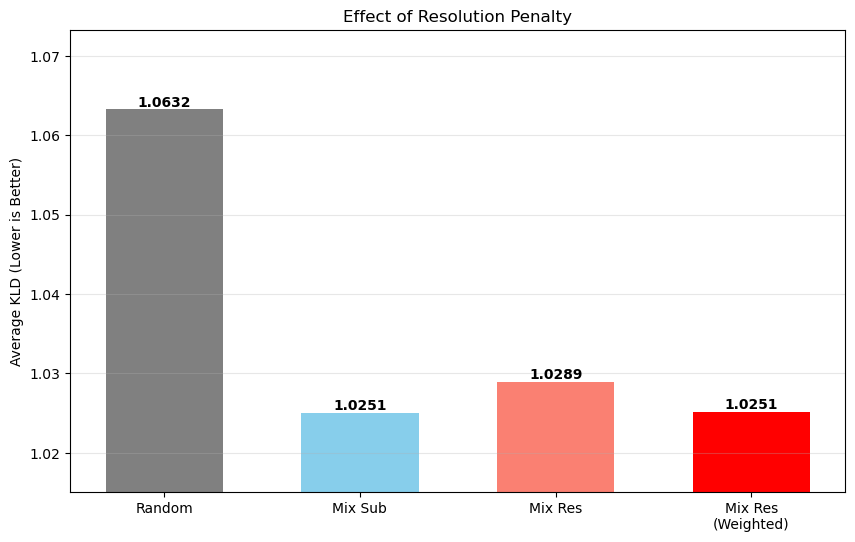

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------
# 1. 데이터 준비
# -------------------------------------------------------
# target_df (또는 valid_df)가 메모리에 있다고 가정합니다.
# 이전에 계산한 'img_resolution', 'visual_sim', 'object_score' 컬럼이 필요합니다.
# 만약 없다면 이전 단계 코드를 실행해 df를 만드셔야 합니다.

# 복사본 생성
final_df = target_df.copy()

# -------------------------------------------------------
# 2. 정규화 (Normalization)
# -------------------------------------------------------
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# 기존 지표
final_df['norm_sim'] = normalize(final_df['visual_sim'])
# 주의: mix_sub에 쓰인건 object_score(CLIP) 였습니다. obj_scale(DINO)이 아니라요.
# 만약 mix_sub가 이미 컬럼에 있다면 그대로 쓰셔도 됩니다.
if 'object_score' in final_df.columns:
    final_df['norm_obj'] = normalize(final_df['object_score'])
else:
    # 혹시 DINO scale만 있고 CLIP score가 없다면 로드 필요
    print("Warning: 'object_score' (CLIP) column missing. Using 'obj_scale' instead if available.")
    final_df['norm_obj'] = normalize(final_df['obj_scale'])

# 새로운 지표: 해상도
final_df['norm_res'] = normalize(final_df['img_resolution'])

# -------------------------------------------------------
# 3. 새로운 조합 생성 (Resolution Penalty)
# -------------------------------------------------------
# (A) Mix Sub (Baseline Champion)
# Score = Sim - Obj
final_df['mix_sub'] = final_df['norm_sim'] - final_df['norm_obj']

# (B) Mix Res (Challenger)
# Score = Sim - Obj - Resolution
# 해상도가 클수록(norm_res가 1에 가까울수록) 점수를 깎습니다.
final_df['mix_res'] = final_df['mix_sub'] - final_df['norm_res']

# (C) Mix Res Weighted (가중치 조절)
# 해상도 영향력이 너무 클 수 있으니 0.5 정도만 반영
final_df['mix_res_weighted'] = final_df['mix_sub'] - (0.5 * final_df['norm_res'])

# -------------------------------------------------------
# 4. 상관관계 비교
# -------------------------------------------------------
check_cols = ['kld', 'mix_sub', 'mix_res', 'mix_res_weighted']
corr = final_df[check_cols].corr()

print("📊 Correlation with KLD (Target: Lower than -0.22)")
print(corr['kld'].sort_values())

# -------------------------------------------------------
# 5. 최종 성능 시뮬레이션 (Top-1 Selection Mean KLD)
# -------------------------------------------------------
print("\n" + "="*50)
print("🏁 Final Performance Simulation (Mean KLD)")
print("="*50)

# Random
random_kld = final_df.groupby('case_id')['kld'].mean().mean()

# Champion: Mix Sub
idx_champ = final_df.groupby('case_id')['mix_sub'].idxmax()
kld_champ = final_df.loc[idx_champ]['kld'].mean()

# Challenger: Mix Res
idx_res = final_df.groupby('case_id')['mix_res'].idxmax()
kld_res = final_df.loc[idx_res]['kld'].mean()

# Challenger: Mix Res Weighted
idx_res_w = final_df.groupby('case_id')['mix_res_weighted'].idxmax()
kld_res_w = final_df.loc[idx_res_w]['kld'].mean()

print(f"1. Random Baseline      : {random_kld:.4f}")
print(f"2. Mix Sub (Sim-Obj)    : {kld_champ:.4f}")
print(f"3. Mix Res (Sim-Obj-Res): {kld_res:.4f}")
print(f"4. Mix Res (Weighted)   : {kld_res_w:.4f}")
print("-" * 50)

best_kld = min(kld_champ, kld_res, kld_res_w)
if best_kld < kld_champ:
    print(f"🎉 Resolution Penalty Works! Gain: {kld_champ - best_kld:.5f}")
else:
    print("🤔 Resolution penalty didn't help overall.")

# -------------------------------------------------------
# 6. 시각화
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
methods = ['Random', 'Mix Sub', 'Mix Res', 'Mix Res\n(Weighted)']
scores = [random_kld, kld_champ, kld_res, kld_res_w]
colors = ['gray', 'skyblue', 'salmon', 'red']

bars = plt.bar(methods, scores, color=colors, width=0.6)
plt.ylim(min(scores) - 0.01, max(scores) + 0.01)
plt.ylabel("Average KLD (Lower is Better)")
plt.title("Effect of Resolution Penalty")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}', 
             ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.show()

In [16]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from groundingdino.util.inference import load_model, load_image, predict


# ------------------------------------------------
# 2. 사람 수 세기 함수
# ------------------------------------------------
BOX_THRESHOLD = 0.35  # 사람이라고 확신할 수 있는 임계값
TEXT_THRESHOLD = 0.25

def get_person_count(row):
    try:
        image_path = row['exo_path']
        image_source, image = load_image(image_path)
        
        # "person" 텍스트로 감지
        boxes, logits, phrases = predict(
            model=model,
            image=image,
            caption="person",
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD
        )
        
        # 감지된 박스 개수 반환
        return len(boxes)

    except Exception as e:
        # print(f"Error: {e}")
        return 0

# ------------------------------------------------
# 3. 계산 실행
# ------------------------------------------------
# final_df (이전 단계 데이터프레임) 사용
count_df = final_df.copy()

tqdm.pandas()
print("🚀 Counting People in Images...")
count_df['person_count'] = count_df.progress_apply(get_person_count, axis=1)


🚀 Counting People in Images...


100%|██████████| 2156/2156 [04:15<00:00,  8.44it/s]



📊 Linear Correlation (Person Count vs KLD):
   Corr: 0.0513
📊 Deviation Correlation (|Count - 1| vs KLD):
   Corr: 0.0501 (Positive is Good Hypothesis)

📦 Average KLD by Person Count:

🏁 Final Performance Simulation
1. Random Baseline      : 1.0632
2. Previous Best (Res)  : 1.0251
3. New Best (Person Cnt): 1.0562
--------------------------------------------------
🤔 Person count filter didn't help.


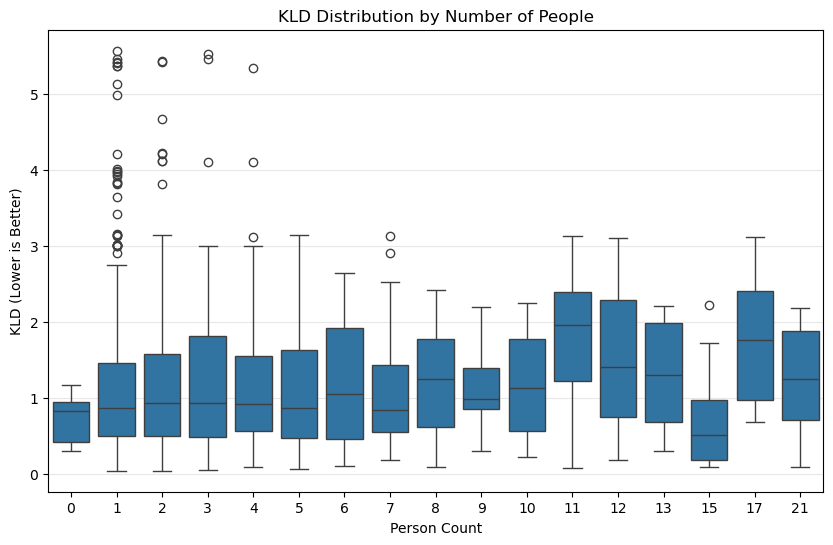

In [17]:
# ------------------------------------------------
# 4. 분석: 상관관계 및 그룹별 평균
# ------------------------------------------------

# (A) 단순 선형 상관관계 확인
# 주의: 1명이 좋고 2명이 나쁘면, 선형 상관계수는 0에 가까울 수 있음 (비선형이므로)
cols = ['kld', 'person_count']
corr = count_df[cols].corr()
print("\n📊 Linear Correlation (Person Count vs KLD):")
print(f"   Corr: {corr.loc['kld', 'person_count']:.4f}")

# (B) "1명과의 거리" 상관관계 확인 (가설: 1명에서 멀어질수록 나쁘다)
# |count - 1| 값이 클수록 KLD가 높은지(양의 상관관계) 확인
count_df['dist_from_one'] = abs(count_df['person_count'] - 1)
cols2 = ['kld', 'dist_from_one']
corr2 = count_df[cols2].corr()
print(f"📊 Deviation Correlation (|Count - 1| vs KLD):")
print(f"   Corr: {corr2.loc['kld', 'dist_from_one']:.4f} (Positive is Good Hypothesis)")

# (C) 사람 수 별 평균 KLD (가장 중요!)
print("\n📦 Average KLD by Person Count:")
summary = count_df.groupby('person_count')['kld'].agg(['mean', 'count', 'std'])
# print(summary)

# ------------------------------------------------
# 5. 최종 전략 시뮬레이션
# ------------------------------------------------
# 가설: 사람이 1명인 이미지가 Best다.
# 전략: 사람이 1명이 아니면(0명, 2명 이상) 기존 점수에서 감점(Penalty)

# 기존 Best Score (Mix Res Weighted)
# Score = Sim - Obj - 0.5*Res
if 'mix_res_weighted' not in count_df.columns:
    # 없으면 재계산
    def norm(s): return (s - s.min()) / (s.max() - s.min())
    count_df['mix_res_weighted'] = (norm(count_df['visual_sim']) - 
                                    norm(count_df['object_score']) - 
                                    0.5 * norm(count_df['img_resolution']))

# 페널티 적용: 1명이면 0, 아니면 0.3 감점
# (가중치 0.3은 실험적으로 조정 가능)
count_df['penalty_person'] = count_df['person_count']#.apply(lambda x: 0.0 if x == 1 else 0.3)

# New Score = Old Best - Penalty
count_df['mix_final_person_count'] = count_df['mix_res_weighted'] + 0.3* count_df['penalty_person']

# 성능 비교
print("\n" + "="*50)
print("🏁 Final Performance Simulation")
print("="*50)

# Random
rand_kld = count_df.groupby('case_id')['kld'].mean().mean()

# Previous Best
idx_prev = count_df.groupby('case_id')['mix_res_weighted'].idxmax()
kld_prev = count_df.loc[idx_prev]['kld'].mean()

# New Best (With Person Count Penalty)
idx_new = count_df.groupby('case_id')['mix_final_person_count'].idxmax()
kld_new = count_df.loc[idx_new]['kld'].mean()

print(f"1. Random Baseline      : {rand_kld:.4f}")
print(f"2. Previous Best (Res)  : {kld_prev:.4f}")
print(f"3. New Best (Person Cnt): {kld_new:.4f}")
print("-" * 50)

if kld_new < kld_prev:
    print(f"🎉 Success! Gain: {kld_prev - kld_new:.5f}")
else:
    print("🤔 Person count filter didn't help.")

# ------------------------------------------------
# 6. 시각화
# ------------------------------------------------
plt.figure(figsize=(10, 6))

# 데이터 개수가 너무 적은(5개 미만) 카테고리는 제외하고 시각화
valid_counts = summary[summary['count'] > 5].index
plot_data = count_df[count_df['person_count'].isin(valid_counts)]

sns.boxplot(data=plot_data, x='person_count', y='kld')
plt.title("KLD Distribution by Number of People")
plt.xlabel("Person Count")
plt.ylabel("KLD (Lower is Better)")
plt.grid(axis='y', alpha=0.3)
plt.savefig("person_count_analysis.png")
plt.show()

In [36]:
# ------------------------------------------------
# 1. 정규화 (Normalization) - 필수!
# ------------------------------------------------
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# 사람 수를 0.0 ~ 1.0 사이로 변환 (예: 0명=0.0, 20명=1.0)
count_df['norm_person'] = normalize(count_df['person_count'])

# ------------------------------------------------
# 2. 페널티 적용 (Subtraction)
# ------------------------------------------------
# [기존] mix_res_weighted (Sim - Obj - Res)
# [수정] 사람 수(norm_person)가 클수록 점수를 깎습니다.
# 가중치 0.2 정도가 적당해 보입니다 (상관계수가 0.06으로 약한 편이라 너무 세게 주면 안 됨)

weight = -0.4
count_df['mix_final_person_count'] = count_df['mix_res_weighted'] + (weight * count_df['norm_person'])

# ------------------------------------------------
# 3. 최종 성능 비교
# ------------------------------------------------
print("\n" + "="*50)
print("🏁 Ultimate Selection Strategy Performance")
print("="*50)

# 1. Random
rand_kld = count_df.groupby('case_id')['kld'].mean().mean()

# 2. Previous Best (Mix Res Weighted)
idx_prev = count_df.groupby('case_id')['mix_res_weighted'].idxmax()
kld_prev = count_df.loc[idx_prev]['kld'].mean()

# 3. Final Best (Person Penalty Added)
idx_final = count_df.groupby('case_id')['mix_final_person_count'].idxmax()
kld_final = count_df.loc[idx_final]['kld'].mean()

print(f"1. Random Baseline       : {rand_kld:.4f}")
print(f"2. Previous Best (Res)   : {kld_prev:.4f}")
print(f"3. Final Best (Person)   : {kld_final:.4f}")
print("-" * 50)

gain = kld_prev - kld_final
if gain > 0:
    print(f"🎉 Improved by {gain:.5f}!")
    print("Conclusion: 'Crowded scenes distract the model.'")
else:
    print(f"📉 No gain ({gain:.5f}). The penalty might be too strong or weak.")


🏁 Ultimate Selection Strategy Performance
1. Random Baseline       : 1.0632
2. Previous Best (Res)   : 1.0251
3. Final Best (Person)   : 1.0235
--------------------------------------------------
🎉 Improved by 0.00166!
Conclusion: 'Crowded scenes distract the model.'



🏁 Ultimate Selection Strategy Performance
1. Random Baseline       : 1.0632
2. Previous Best (Res)   : 1.0251
3. Final Best (Person)   : 1.0235
--------------------------------------------------
🎉 Improved by 0.00166!
Conclusion: 'Crowded scenes distract the model.'


In [19]:
count_df.loc[idx_final]['nss'].mean()

np.float64(1.3802923102332048)

In [20]:
count_df.loc[idx_final]['sim'].mean()

np.float64(0.4665634224175914)

In [21]:
count_df.loc[idx_final]['kld'].mean()

np.float64(1.0234592168722763)

7

In [33]:
count_df[["case_id", "action", "object", "exo_path", "person_count", "norm_person"]].to_pickle("exo_person.pkl")
count_df[["case_id", "action", "object", "exo_path", "person_count", "norm_person"]]

,case_id,action,object,exo_path,person_count,norm_person
0,jump_skis,jump,skis,/home/DATA/AGD20K/Seen/trainset/exocentric/jum...,1,0.023256
1,jump_skis,jump,skis,/home/DATA/AGD20K/Seen/trainset/exocentric/jum...,1,0.023256
2,jump_skis,jump,skis,/home/DATA/AGD20K/Seen/trainset/exocentric/jum...,1,0.023256
3,jump_skis,jump,skis,/home/DATA/AGD20K/Seen/trainset/exocentric/jum...,3,0.069767
4,jump_skis,jump,skis,/home/DATA/AGD20K/Seen/trainset/exocentric/jum...,1,0.023256
...,...,...,...,...,...,...
2151,swing_badminton_racket,swing,badminton_racket,/home/DATA/AGD20K/Seen/trainset/exocentric/swi...,1,0.023256
2152,swing_badminton_racket,swing,badminton_racket,/home/DATA/AGD20K/Seen/trainset/exocentric/swi...,1,0.023256
2153,swing_badminton_racket,swing,badminton_racket,/home/DATA/AGD20K/Seen/trainset/exocentric/swi...,1,0.023256
2154,swing_badminton_racket,swing,badminton_racket,/home/DATA/AGD20K/Seen/trainset/exocentric/swi...,1,0.023256


In [34]:
df_person = pd.read_pickle("exo_person.pkl")
df_person

,case_id,action,object,exo_path,person_count,norm_person
0,jump_skis,jump,skis,/home/DATA/AGD20K/Seen/trainset/exocentric/jum...,1,0.023256
1,jump_skis,jump,skis,/home/DATA/AGD20K/Seen/trainset/exocentric/jum...,1,0.023256
2,jump_skis,jump,skis,/home/DATA/AGD20K/Seen/trainset/exocentric/jum...,1,0.023256
3,jump_skis,jump,skis,/home/DATA/AGD20K/Seen/trainset/exocentric/jum...,3,0.069767
4,jump_skis,jump,skis,/home/DATA/AGD20K/Seen/trainset/exocentric/jum...,1,0.023256
...,...,...,...,...,...,...
2151,swing_badminton_racket,swing,badminton_racket,/home/DATA/AGD20K/Seen/trainset/exocentric/swi...,1,0.023256
2152,swing_badminton_racket,swing,badminton_racket,/home/DATA/AGD20K/Seen/trainset/exocentric/swi...,1,0.023256
2153,swing_badminton_racket,swing,badminton_racket,/home/DATA/AGD20K/Seen/trainset/exocentric/swi...,1,0.023256
2154,swing_badminton_racket,swing,badminton_racket,/home/DATA/AGD20K/Seen/trainset/exocentric/swi...,1,0.023256
